# Dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from mpl_toolkits import mplot3d
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

# Datasets

In [2]:
def plot_data(X, y):
    """Plot 2D or 3D according to X dimension."""
    if X.shape[1] == 1:
        for i in range(y.shape[1]):
            plt.plot(X, y[:,i], '.')
            plt.show()
    if X.shape[1] == 2:
        for i in range(y.shape[1]):
            ax = plt.axes(projection='3d')
            ax.scatter(X[:,0], X[:,1], y[:,i], c=y[:,i], cmap='viridis')
            plt.show()

In [139]:
def get_normal_data(n=1000, plot=False, xy_features=(2,1)):
    """Get normal dataset of x=(n*4,2), y=(n*4,1)."""
    x0 = np.concatenate([
        np.random.normal(20, 2, size=n),
        np.random.normal(20, 2, size=n),
        np.random.normal(40, 2, size=n),
        np.random.normal(40, 2, size=n),
    ])
    x1 = np.concatenate([
        np.random.normal(60, 2, size=n),
        np.random.normal(80, 2, size=n),
        np.random.normal(60, 2, size=n),
        np.random.normal(80, 2, size=n),
    ])
    x0 = np.concatenate([
        np.full((n), 1),
        np.full((n), 1),
        np.full((n), 2),
        np.full((n), 2),
    ])
    x1 = np.concatenate([
        np.full((n), 3),
        np.full((n), 4),
        np.full((n), 3),
        np.full((n), 4),
    ])
    y = np.concatenate([
        np.random.normal(100, 2, size=n),
        np.random.normal(120, 2, size=n),
        np.random.normal(140, 2, size=n),
        np.random.normal(160, 2, size=n),
    ])
    data = np.stack((x0, x1, y), axis=1).astype(np.float32)
    np.random.shuffle(data)
    
    if plot:
        ax = plt.axes(projection='3d')
        ax.scatter(data[:,0], data[:,1], data[:,2], alpha=0.3, c='r')
        plt.show()
    
    return (data[:,:2], np.expand_dims(data[:,2], axis=1)) \
            if xy_features == (2,1) else \
            (np.expand_dims(data[:,0], axis=1), data[:,1:])

X, y shapes: (4000, 2) (4000, 1)


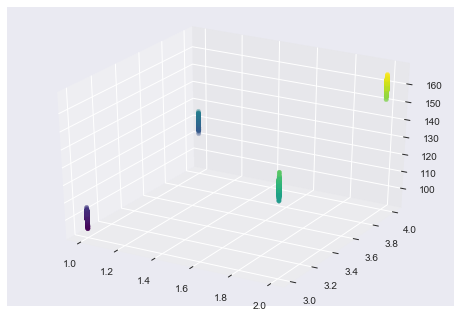

In [140]:
# Use normal dataset
n = 1000
X, y = get_normal_data(n, xy_features=(2,1))
print("X, y shapes:", X.shape, y.shape)

# Plot 2D or 3D graph according to X dimension
plot_data(X, y)

# Convert to TF dataset
n = len(X)
dataset = tf.data.Dataset \
    .from_tensor_slices((X,y)) \
    .shuffle(n).batch(32)

# Gaussian Mixture Density Network

The Gaussian mixture model (GMM) is a probabilistic model for representing normally distributed subpopulations within an overall population. A Gaussian mixture model is parameterized by the mixture component weights, means and covariances. Clusters are modelled as Gaussians not just by their mean but their covariances. The Expectation-Maximisation algorithm assigns data to each cluster with a probability. The GMM gives a probability model of x, a “generative” model.

For each input x, predict a probability density function (pdf) of $P(Y=y|X=x)$ that is a probability weighted sum of smaller Gaussian probability distributions.


$$P(y|x) = \sum_{k}^{K} \Pi_{k}(x) \mathcal{N}(y|\mu_{k}(x), \sigma_{k}^{2}(x))$$

Each parameter $\Pi_{k}(x), \mu_{k}(x), \sigma_{k}(x)$ is approximated by a neural network as a function of input $x$:

$$Z = W_{o} \tanh( W_{h} X + b_{h}) + b_{o}$$

where 

$$\Pi_{k} = \frac{\exp(Z_{k})}{\sum exp(Z)}, \sigma = \exp(Z), \mu = Z$$

Reference:
* https://cedar.buffalo.edu/~srihari/CSE574/Chap5/Chap5.6-MixDensityNetworks.pdf

In [141]:
class GMM:
    """Gaussian Mixture Density Network."""
    def __init__(self, x_features=2, y_features=1, n_components=4, n_hidden=50, verbose=False):
        self.x_features = x_features  # no. of input features
        self.y_features = y_features  # no. of output features
        self.n_components = n_components  # no. of components
        self.n_hidden = n_hidden  # no. of hidden units 
        self.verbose = verbose
        self.build()
    
    def build(self):
        """Compile TF model."""
        input = tf.keras.Input(shape=(self.x_features,))
        layer = tf.keras.layers.Dense(self.n_hidden, activation='tanh')(input)

        mu = tf.keras.layers.Dense(self.n_components * self.y_features)(layer)
        sigma = tf.keras.layers.Dense(self.n_components * self.y_features, activation='exponential')(layer)
        pi = tf.keras.layers.Dense(self.n_components, activation='softmax')(layer)

        self.model = tf.keras.models.Model(input, [pi, mu, sigma])
        self.optimizer = tf.keras.optimizers.Adam()
        
        if self.verbose:
            print(self.model.summary())
        
    def tfdGMM(self, pi, mu, sigma):
        """Tensorflow Probability Distributions GMM."""
        mu = tf.reshape(mu, (self.n_components, self.y_features))
        sigma = tf.reshape(sigma, (self.n_components, self.y_features))
        return tfd.MixtureSameFamily(
            mixture_distribution=tfd.Categorical(probs=pi),
            components_distribution=tfd.MultivariateNormalDiag(loc=mu,
                                                               scale_diag=sigma))

    def loss(self, y, pi, mu, sigma):
        """Loss function, negative log-likelihood."""
        samples = pi.shape[0]
        losses = 0
        for i in range(samples):
            gmm = self.tfdGMM(pi[i], mu[i], sigma[i])
            loss = gmm.log_prob(y[i])
            loss = tf.negative(loss)
            losses += loss
        return losses / samples
    
    @tf.function
    def train_step(self, X, y):
        """TF train function."""
        with tf.GradientTape() as t:
            pi, mu, sigma = self.model(X, training=True)
            loss = self.loss(y, pi, mu, sigma)
        gradients = t.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
        return loss
    
    def fit(self, dataset, epochs=1000, plot=False):
        """Fit with TF dataset."""
        losses = []
        print_every = int(0.1 * epochs)
        
        for i in range(epochs):
            for train_x, train_y in dataset:
                loss = self.train_step(train_x, train_y)
            losses.append(loss)
            if self.verbose and i % print_every == 0:
                print('Epoch {}/{}: Negative Log-Likelihood {}'.format(i, epochs, losses[-1]))
        
        if plot:
            plt.plot(range(len(losses)), losses)
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.title('Negative Log-Likelihood')
            plt.show()
            
    def prob(self, X, y):
        """Compute probability of y given X."""
        pi, mu, sigma = self.model(X) 
        samples = pi.shape[0]
        y_prob = []
        for i in range(samples):
            y_prob.append(self.tfdGMM(pi[i], mu[i], sigma[i]).prob(y[i]).numpy())
        return np.array(y_prob)
        
    def predict(self, X):
        """Sample y given X."""
        pi, mu, sigma = self.model(X) 
        samples = pi.shape[0]
        y_pred = []
        for i in range(samples):
            y_pred.append(self.tfdGMM(pi[i], mu[i], sigma[i]).sample().numpy())
        return np.array(y_pred)
    
    def plot_probability(self, X_fixed, y_range, n_tiles=20):
        """Plot probability density function given X_fixed across y_range."""
        X = np.stack([np.full(n_tiles, fill_value=x) for x in X_fixed], axis=1)
        y = np.linspace(y_range[0], y_range[1], n_tiles)

        y_prob = self.prob(X, y)
        plt.title(f"X={X_fixed}, y={y_range}")
        plt.scatter(y, y_prob, c=y_prob, cmap='viridis')
        plt.show()

# Model Training

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 10)           30          input_3[0][0]                    
__________________________________________________________________________________________________
dense_11 (Dense)                (None, 4)            44          dense_8[0][0]                    
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 4)            44          dense_8[0][0]                    
____________________________________________________________________________________________

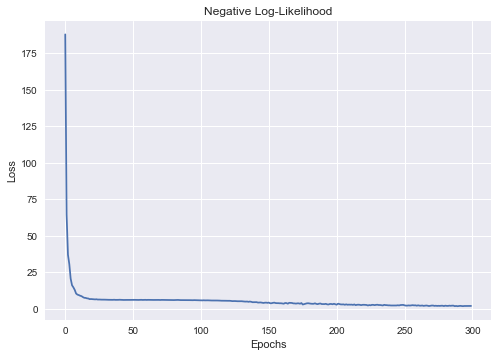

In [142]:
# Build GMM
gmm = GMM(x_features=X.shape[1],
          y_features=y.shape[1],
          n_components=4,
          n_hidden=10, verbose=True)
gmm.fit(dataset, epochs=300, plot=True)

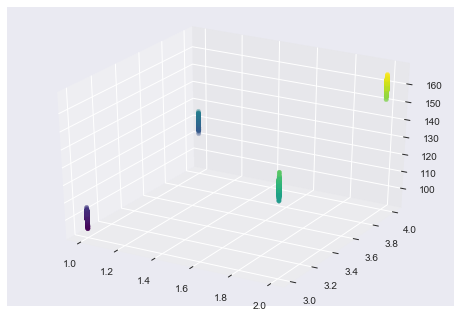

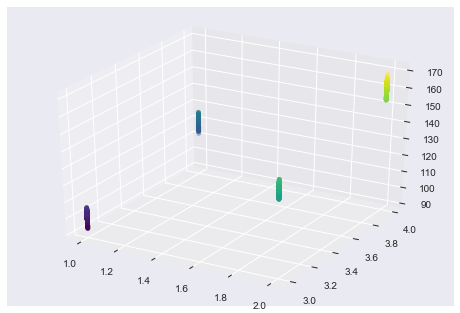

In [143]:
y_hat = gmm.predict(X)
plot_data(X, y)
plot_data(X, y_hat)

# Probability Density Visualisation

In [50]:
import seaborn as sns

def plot_violin(density1, density2, feature):
    df = pd.DataFrame({
        'density': np.concatenate([density1, density2]),
        'feature': [feature] * len(density1) * 2,
        'distribution': ["actual"] * len(density1) + ["fitted"] * len(density2)
    })

    sns.violinplot(x="feature", y="density", hue="distribution",
                   data=df, split=True)
    plt.show()
    return df

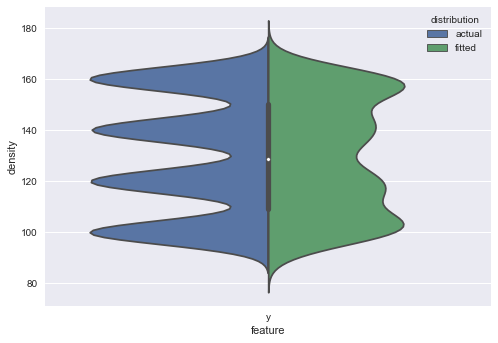

In [56]:
y_hat = gmm.predict(X)
plot_violin(y[:,0], y_hat[:,0], "y");

In [145]:
np.digitize([1,2,3,4], bins=np.histogram([1,2,3,4], bins=3)[1])

array([1, 2, 3, 4], dtype=int64)

In [64]:
def plot_prob(gmm, X_fixed, y):
    X = np.stack([np.full(y.shape[0], fill_value=x) for x in X_fixed], axis=1)
    y_hat = gmm.predict(X)
    print(y_hat.shape, y.shape)
    for y_col in range(y_hat.shape[1]):
        plot_violin(y, y_hat[:,y_col], y_col)

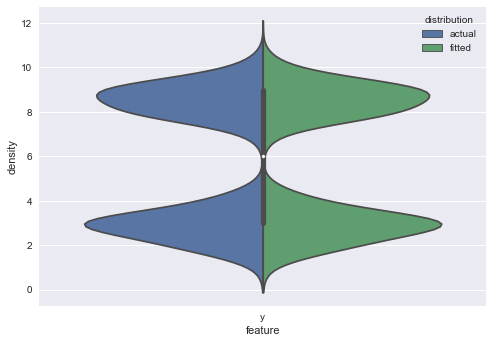

In [134]:
bins = 10

pdf, labels = np.histogram(X[:,0], bins=bins)
dig = np.digitize(X[:,0], bins=labels)
plot_violin(dig, dig, "y");

In [128]:
centres = labels[:-1] + (labels[1] - labels[0])/2

In [132]:
X[:,0].shape[0] / len(centres)

1333.3333333333333

In [55]:
def plot_probability(gmm, X_fixed, y_range, n_tiles=20):
    """Plot probability density function given X_fixed across y_range."""
    X = np.stack([np.full(n_tiles, fill_value=x) for x in X_fixed], axis=1)
    y = np.linspace(y_range[0], y_range[1], n_tiles)

    y_prob = gmm.prob(X, y)
    plt.title(f"X={X_fixed}, y={y_range}")
    plt.scatter(y, y_prob, c=y_prob, cmap='viridis')
    plt.show()

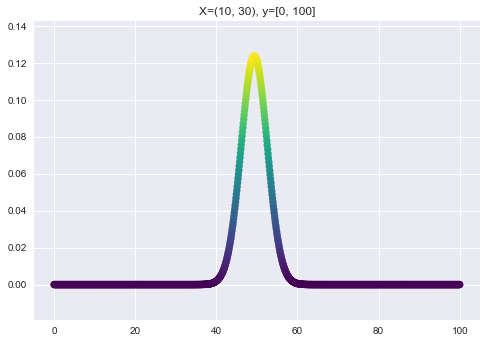

In [9]:
gmm.plot_probability(X_fixed=(10,30), y_range=[0,100], n_tiles=1000)

In [10]:
def plot_density(X1, X2, bins=20):
    pdf, x1, x2 = np.histogram2d(X1, X2, bins=bins, density=True)
    xmesh, ymesh = np.meshgrid(x1[:-1], x2[:-1])
    ax = plt.axes(projection='3d')
    ax.plot_surface(xmesh, ymesh, pdf, cmap='viridis')
    plt.show()
    return pdf

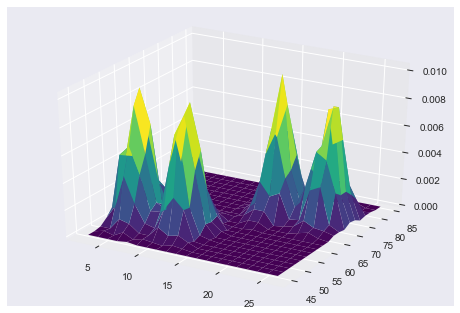

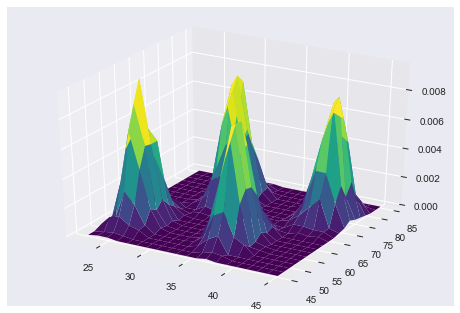

In [11]:
plot_density(X[:,0], y[:,0], bins=20);
plot_density(X[:,1], y[:,0], bins=20);

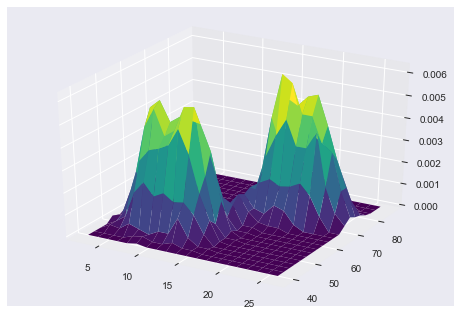

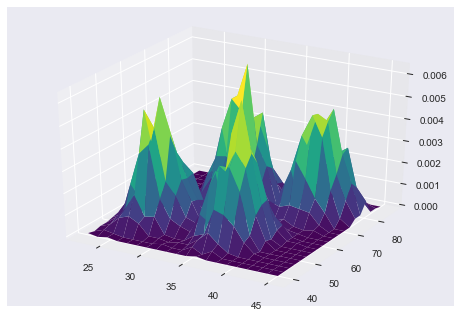

In [12]:
plot_density(X[:,0], y_hat[:,0], bins=20);
plot_density(X[:,1], y_hat[:,0], bins=20);

In [13]:
def compute_probs(data, n=10): 
    h, e = np.histogram(data, n)
    p = h/data.shape[0]
    return e, p

In [14]:
a = np.linspace(0,10,10)
compute_probs(a, n=10)

(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]))

In [15]:
from scipy.special import softmax

pdf, bins = np.histogram(a, bins=10, density=True)
pdf, bins

(array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]))